#  Import libraries

In [7]:
from math import *
from sympy import *
from ipywidgets import *
from IPython.display import display,clear_output,HTML
import numpy as np
import matplotlib.pyplot as plt

# Styling

In [8]:
%%html
<style>
textarea, input {
    font-family: Arial, Helvetica, sans-serif;
    text-align: center;
    flex_flow=row,
}
left-spacing-class {margin-left: 10px;}

:root {
    --jp-ui-font-size1: 16px;
    
}
</style>

In [9]:
CSS = """
.output {
    display: flex;
    align-items: left;
    justify-content:center;
    text-align: center;
}
.widget-label { min-width: 14ex !important; }
.widget-text { width: auto; }
-button{
    background-color: #689e5f
}
"""

HTML('<style>{}</style>'.format(CSS))

# Input processing and Algorithms

In [10]:
#Parse input string to the right format
def get_func(s):
    import re
    # step1: trim all whitespaces
    s = re.sub(r'\s+',"",s).replace('e**','e^')
    #step2: convert e^() to exp(), e^__ to exp(x), ln__ to ln()
    s = re.sub(r"[e]\^\((\w*)",r"exp(\1",s) 
    s = re.sub('e\^([0-9a-z.]*)','exp(\g<1>)',s) 
    s = re.sub(r"ln([0-9a-z.()]*)",r'ln(\g<1>)',s) 
    #step3.1: add * between 2 consecutive alphabetical characters | a digit and an alphabetical character
    s = re.sub('(?i)(?<=[a-z0-9])(?=[a-z])',r'*',s) 
    #step3.2: add * between an alphabetical character and a digit
    s = re.sub('(?i)(?<=[a-z])(?=[0-9])',r'*',s) 
    #step3.3 add * between number and open bracket
    s = re.sub('(?<=[a-z0-9])(?=[([{])',r'*',s)
    #step3.4 add * between closing bracket and number or open bracket, fix error from step3
    s = re.sub('(?:(?<=[)])|(?<=[}])|(?<=[]]))(?:(?=([a-z0-9]))|(?=[({[]))',r'*',s)
    s = s.replace("l*n*","ln").replace("l*o*g*","log").replace("t*a*n*","tan").replace("c*o*s*","cos").replace("s*i*n*","sin").replace("e*x*p*","exp").replace("^","**").replace('−','-')
    return s
#return the expression f(x) = f'(x)(x-x0) + y0 
def location_equation(y,x0,y0):
    return f"{y}-({str(diff(y))})*x+({str(diff(y))})*{x0}-{y0}"
#solve the equation
def secant(y, a, b, eps=10e-7):
    try: #if the arbitrary equation cannot be solved by built-in solve(), then use secant's method
        from sympy.solvers import solve
        return solve(y)
    except:
        f = lambda x: eval(y)
        f_a = f(a)
        f_b = f(b)
        iteration_counter = 0
        while abs(f_b) > eps and iteration_counter < 1000000:
            try:
                denominator = float(f_b - f_a)/(b - a)
                x = b - float(f_b)/denominator
            except ZeroDivisionError:
                return ""
            a = b
            b = x
            f_a = f_b
            f_b = f(b)
            iteration_counter += 1
        if x:
            return round(x, 4)
def arclen_approx(y,a,b,N=10000):
    dx = str(diff(y))
    delta_x = (b-a)/N
    f= lambda x: eval(f"sqrt(1+({dx})*({dx}))")   
    sigma = sum(f(a + k*delta_x) for k in range(1,N))    
    return round(delta_x*(sigma +(f(a)+f(b))/2),3)

# Plotting 

Button(description='Compute', layout=Layout(width='auto'), style=ButtonStyle(button_color='lightgreen'), toolt…

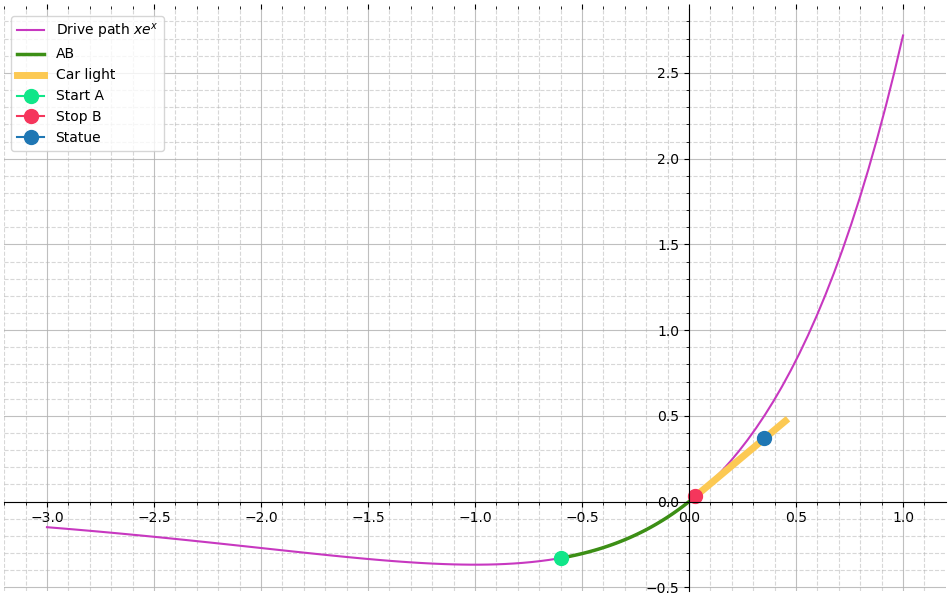

In [12]:
%matplotlib widget
#Create UI
path_expr = widgets.Text(value='xe^x',placeholder='Write down function f(x) for pathway',description="Pathway 🛣️",layout=Layout(flex='0.01 1 40%', width='50%'),style= {'width': 'initial'})
start_x = widgets.Text(value='-0.6',description="Start A",placeholder='x',layout=Layout(flex='0.4 1 100%', width='50px'))
speed = widgets.Text(value='60',description='Speed (km/h)',placeholder='km/h',layout=Layout(flex='0.4 1 100%', width='30px'))
statue_xcoor = widgets.Text(value='0.35',description="Statue 🗿",placeholder='x',layout=Layout(flex='0.4 1 100%', width='40px'))
statue_ycoor = widgets.Text(value='0.37',placeholder='y',layout=Layout(flex='0.3 1 40%', width='10px'))
res_car = widgets.Text(value='',description="Car🚗 ",placeholder='Position',layout=Layout(flex='0.5 1 100%', width='auto'))
checkbox = widgets.Checkbox(value=True,description="Light 💡",indent=False)
button_compute = widgets.Button(description='Compute',layout={'width': 'auto'},tooltip = "Make magic",style = dict(button_color = 'lightgreen'))
res_len = widgets.Text(value='',description="Pathlength AB ≈",placeholder='meters',layout=Layout(flex='0.1 1 100%', width='auto'))
res_time = widgets.Text(value='',description="Time ⌚ ≈",placeholder='seconds',layout=Layout(flex='0.1 1 100%',width='40px'))
x1 = widgets.Text(value='-3',layout=Layout(display="flex", justify_content="center", width="50px"))
x2 = widgets.Text(value='1',layout=Layout(display="flex", justify_content="center", width="50px"))
label = widgets.Label(r"≤ 𝑥 ≤",layout=Layout(display="flex", justify_content="center", width="2px"))
#Display UI
display(widgets.HBox([path_expr,start_x,speed,statue_xcoor,statue_ycoor]))
display(widgets.HBox([x1,label,x2]))
display(button_compute)
#global variables
fig,ax,path,light,res,y,b_xcoor= None,None,None,None,None,None,None
#Event handlers
def light(change):
    if change.new:
        light.set_data([b_xcoor,eval(statue_xcoor.value)+0.1],
                               [y(b_xcoor),eval(statue_ycoor.value)+0.1])
        fig.canvas.draw()
    else:
        light.set_data([],[])
        fig.canvas.draw()
def compute(event):
    clear_output(wait=True)
    res_car.value,res_time.value,res_len.value="","",""
    try:           
        global fig,ax,path,light,res,y,b_xcoor
        if path_expr.value and start_x.value and statue_xcoor.value and statue_ycoor.value:

            iteration = [t for t in np.linspace(eval(x1.value),eval(x2.value), 100)]                      
            fx = get_func(path_expr.value)
            y = lambda x: eval(fx)
            f = location_equation(fx,eval(statue_xcoor.value),eval(statue_ycoor.value))   
            
            if type(secant(f,0,0))!=list:
                res = list(set(filter(None,(secant(f,i,i+1) for i in range(-5,5)))))
                res[:] =[i for i in res if i<eval(statue_xcoor.value)] 
            else:
                res = secant(f,-5,5)
                res[:]=[i for i in res if i<eval(statue_xcoor.value)]              
            b_xcoor = round(float(res[0]),4)
            res_car.value= f'({b_xcoor},{round(y(b_xcoor),4)})'
            path = arclen_approx(fx,eval(start_x.value),b_xcoor)*1000
            res_len.value = f"{path} m"
            if speed.value:
                res_time.value = f"{round(path*3.6/eval(speed.value),2)} s"
            display(widgets.HBox([path_expr,start_x,speed,statue_xcoor,statue_ycoor]))
            display(widgets.HBox([x1,label,x2]))
            display(widgets.HBox([res_car,checkbox,res_time,res_len]))
            display(button_compute)
            #plot elements                       
            fig,ax = plt.subplots(constrained_layout=True, figsize=(9.5,6))
            fig.canvas.toolbar_position = 'bottom'
            fig.canvas.header_visible = False
            
            ax.plot(iteration,[y(i) for i in iteration],label=f"Drive path ${latex(sympify(fx))}$",color="#c738c0")           
            ax.plot([i for i in np.linspace(eval(start_x.value),b_xcoor)],
                    [y(i) for i in np.linspace(eval(start_x.value),b_xcoor)],
                   label="AB",linewidth=2.5,color="#3C8F15")         
            light, = ax.plot([],[],color="#fcc953",linewidth=5,label="Car light")
            ax.plot(eval(start_x.value),y(eval(start_x.value)),label="Start A",marker='o', markersize=10,color="#10e689")
            ax.plot(b_xcoor,y(b_xcoor),label="Stop B",marker='o', markersize=10,color="#f5365c")   
            
            if checkbox.value:
                light.set_data([b_xcoor,eval(statue_xcoor.value)+0.1],
                               [y(b_xcoor),eval(statue_ycoor.value)+0.1])
                fig.canvas.draw()
            
            ax.plot(eval(statue_xcoor.value),eval(statue_ycoor.value),label="Statue",marker='o', markersize=10)
            #customize graph
            ax.spines['bottom'].set_position(('data',0))
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
            ax.xaxis.set_ticks_position('default')
            ax.yaxis.set_ticks_position('left')
            ax.spines['left'].set_position(('data',0)) 
            ax.minorticks_on()
            ax.grid(visible=True, which='major', axis='both', alpha=0.8)
            ax.grid(visible=True, which='minor', axis='both', alpha=0.5,linestyle='dashed')
            ax.autoscale(enable=True, axis='both', tight=None)
            ax.legend(loc=2, prop={'size': 10})
           
    except:
        clear_output(wait=True)
        display(widgets.HBox([path_expr,start_x,speed,statue_xcoor,statue_ycoor]))
        display(widgets.HBox([x1,label,x2]))
        display(button_compute)
        display('CANNOT COMPUTE!')
checkbox.observe(light,'value')
button_compute.on_click(compute)
